<a href="https://colab.research.google.com/github/mykon23/DL-2020Project/blob/pretrained_and_architecture/Equus7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Get the Equus Dataset

In [1]:
! wget -O Equus.tar.gz https://github.com/mykon23/DL-2020Project/blob/master/Equus.tar.gz?raw=true

--2020-04-30 22:44:48--  https://github.com/mykon23/DL-2020Project/blob/master/Equus.tar.gz?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mykon23/DL-2020Project/raw/master/Equus.tar.gz [following]
--2020-04-30 22:44:48--  https://github.com/mykon23/DL-2020Project/raw/master/Equus.tar.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mykon23/DL-2020Project/master/Equus.tar.gz [following]
--2020-04-30 22:44:48--  https://raw.githubusercontent.com/mykon23/DL-2020Project/master/Equus.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting resp

In [0]:
! rm -rf Equus
! tar -zxf Equus.tar.gz

In [0]:
! rm *.tar.gz
! rm -rf train/
! rm -rf validation/
! rm -rf test/

Create the Training Set, Validation Set, and Test Set

In [0]:
import os

##Creates the folder structure of the data staging locations
def set_dataset_loc(loc, sub_dirs):
  if not os.path.exists(loc):
    os.mkdir(loc)
    for s in sub_dirs:
      os.mkdir(os.path.join(loc, s))


dataset_dir = os.path.join('.', 'Equus')
lst_members = os.listdir(dataset_dir)

set_dataset_loc(os.path.join('.', 'train'), lst_members)
set_dataset_loc(os.path.join('.', 'validation'), lst_members)
set_dataset_loc(os.path.join('.', 'test'), lst_members)


In [5]:
##Display distribution of data

for d in os.listdir(dataset_dir):
  print(f'{d}: {len(os.listdir(os.path.join(dataset_dir, d)))}')

Horse: 314
Zebra: 339
Donkey: 391


In [6]:
!ls -lh

total 20K
drwxr-xr-x 5 root root 4.0K Mar 16 03:00 Equus
drwxr-xr-x 1 root root 4.0K Apr  3 16:24 sample_data
drwxr-xr-x 5 root root 4.0K Apr 30 22:44 test
drwxr-xr-x 5 root root 4.0K Apr 30 22:44 train
drwxr-xr-x 5 root root 4.0K Apr 30 22:44 validation


In [0]:
import shutil

##Populate the staging locations for the data
def stage_data_loc(stage_loc, data_loc, dict_ind):

  ##Create a dictionary containing the images
  dict_images = { k : os.listdir(os.path.join(data_loc, k)) for k in lst_members }

  for k in dict_images.keys():
    for i in range(dict_ind[k][0], dict_ind[k][1]):
      src = os.path.join(os.path.join(data_loc, k), dict_images[k][i])
      dst = os.path.join(os.path.join(stage_loc, k), dict_images[k][i])
      shutil.copyfile(src, dst)

##Keep indices for the data splits
dict_train = {'Donkey': [0, 240], 'Horse': [0, 185], 'Zebra':[0, 185]}
dict_val = {'Donkey': [240, 315], 'Horse': [185, 250], 'Zebra':[185, 249]}
dict_test = {'Donkey': [315, 391], 'Horse': [250, 314],'Zebra': [249, 339]}

stage_data_loc(os.path.join('.', 'train'), dataset_dir, dict_train)
stage_data_loc(os.path.join('.', 'validation'), dataset_dir, dict_val)
stage_data_loc(os.path.join('.', 'test'), dataset_dir, dict_test)


In [8]:
##Count the number of files within each directory
! ls -lh train/*/* | wc -l
! ls -lh validation/*/* | wc -l
! ls -lh test/*/* | wc -l

610
204
230


Define Train and Test Operations

In [9]:
import keras
import matplotlib.pyplot as plt
import tensorflow as tf

def train_model(model, train, val, model_path):
  ##Set the callbacks
  callback_list = [
  tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    ),
  tf.keras.callbacks.ModelCheckpoint(
      filepath=model_path,
      monitor='val_loss',
      save_best_only=True,
    )
  ]

  ##Train the model
  history = model.fit(
      train['gen'],
      steps_per_epoch=train['steps'],
      epochs=50,
      callbacks = callback_list,
      validation_data=val['gen'],
      validation_steps=val['steps'])
  
  return history

def disp_plot(history, title):
  plt.figure()
  plt.plot(history.history['accuracy'], 'bo', label='Training Acc')
  plt.plot(history.history['val_accuracy'], 'b', label='Validation Acc')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.title(title)
  plt.legend()
  plt.show()

  plt.figure()
  plt.plot(history.history['loss'], 'bo', label='Training Loss')
  plt.plot(history.history['val_loss'], 'b', label='Validation Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.title(title)
  plt.legend()
  plt.show()

def test_model(model, test):
  ##Observe the results of the model against the test data
  test_loss, test_acc = model.evaluate(
    test['gen'],
    steps=test['steps']
  )
  
  return {'accuracy': test_acc, 'loss': test_loss }


Using TensorFlow backend.


Establish Baseline Data Generators

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join('.', 'train')
val_dir = os.path.join('.', 'validation')
test_dir = os.path.join('.', 'test')

train_batches = 61
val_batches = 17
test_batches = 23

##Create Development Set Generators
##Note that 61 * 10 = 610 training samples
train_generator = ImageDataGenerator(rescale=1./255,
                                     ).flow_from_directory(train_dir, target_size=(256, 256), batch_size=10, class_mode='categorical')
##Note that 17 * 12 = 240 validation samples
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir, target_size=(256, 256), batch_size=12, class_mode='categorical')

##Create Test Generator
##Note that 23 * 10 = 230 Test samples
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, target_size=(256,256), batch_size=10, class_mode='categorical')

Found 610 images belonging to 3 classes.
Found 204 images belonging to 3 classes.
Found 230 images belonging to 3 classes.


Observe Benchmark

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        9

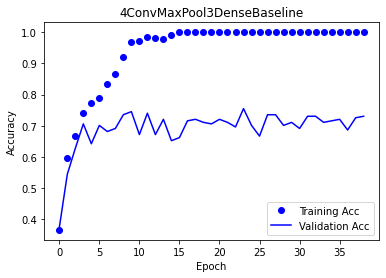

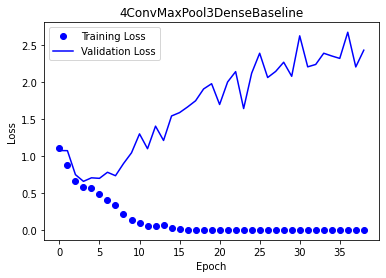

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), activation='relu') )
model.add( Flatten() )
model.add( Dense( 24, activation = 'relu' ) )
model.add( Dense( 12, activation = 'relu' ) )
model.add( Dense( 3, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseBaseline.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [12]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 0s 21ms/step - loss: 0.5760 - accuracy: 0.7217
Test: {'accuracy': 0.7217391133308411, 'loss': 0.5760310292243958}
17/17 [==============================] - 0s 26ms/step - loss: 0.7661 - accuracy: 0.6569
Val: {'accuracy': 0.656862735748291, 'loss': 0.7661241888999939}
61/61 [==============================] - 1s 22ms/step - loss: 0.5632 - accuracy: 0.7705
Train: {'accuracy': 0.7704917788505554, 'loss': 0.5632055997848511}


Observe VGG16 as Convolution Base (Feature Extraction)

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 24)                786456    
_________________________________________________________________
dense_4 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 39        
Total params: 15,501,483
Trainable params: 786,795
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/50
61/61 [===================

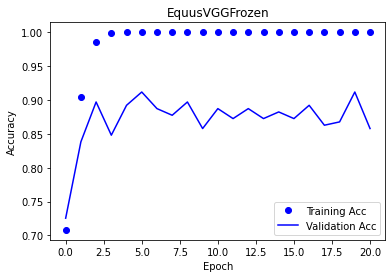

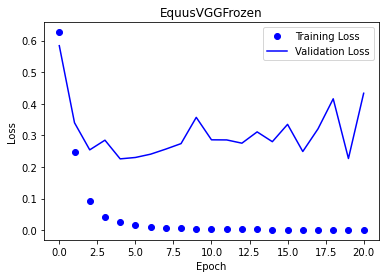

In [13]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

##Set the convolution base as VGG16 and freeze weights
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
conv_base.trainable = False

model = Sequential()
model.add(conv_base)
model.add( Flatten() )
model.add( Dense( 24, activation = 'relu' ) )
model.add( Dense( 12, activation = 'relu' ) )
model.add( Dense( 3, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = 'EquusVGGFrozen.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [14]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 2s 90ms/step - loss: 0.2199 - accuracy: 0.9087
Test: {'accuracy': 0.908695638179779, 'loss': 0.219881072640419}
17/17 [==============================] - 2s 102ms/step - loss: 0.2398 - accuracy: 0.8971
Val: {'accuracy': 0.8970588445663452, 'loss': 0.23983456194400787}
61/61 [==============================] - 6s 92ms/step - loss: 0.0151 - accuracy: 1.0000
Train: {'accuracy': 1.0, 'loss': 0.015131677500903606}


Observe Fine-Tuning of Convolution Base (Single Layer)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

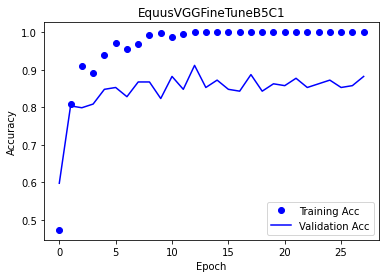

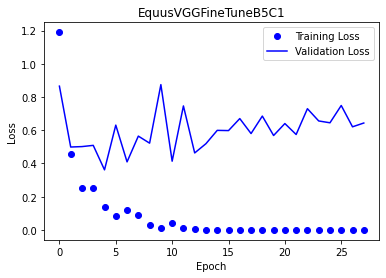

In [15]:
##Load the model weights from Feature extraction
model.load_weights(model_path)
conv_base.summary()

##Unfreeze a layer from the convolution base
conv_base.trainable = True
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    layer.trainable = True
  else:
    layer.trainable = False

model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = 'EquusVGGFineTuneB5C1.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [16]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 2s 90ms/step - loss: 0.1838 - accuracy: 0.9348
Test: {'accuracy': 0.9347826242446899, 'loss': 0.1837931126356125}
17/17 [==============================] - 2s 102ms/step - loss: 0.4425 - accuracy: 0.8088
Val: {'accuracy': 0.8088235259056091, 'loss': 0.44251129031181335}
61/61 [==============================] - 6s 92ms/step - loss: 0.0753 - accuracy: 0.9770
Train: {'accuracy': 0.9770491719245911, 'loss': 0.07527383416891098}


Observe Training with ResNet50 model

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

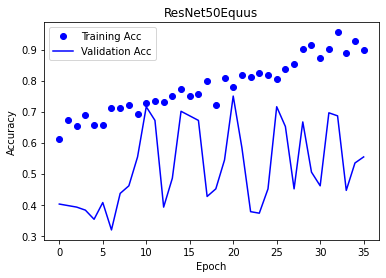

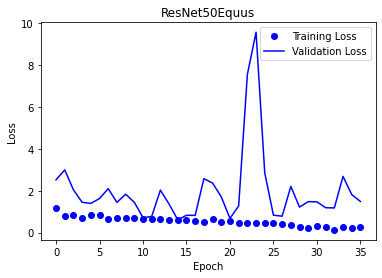

In [17]:
from tensorflow.keras.applications import ResNet50

##Set the ResNet50 model for equus classification
model = ResNet50(include_top=True, weights=None, input_shape=(256, 256, 3), classes=3)
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = 'ResNet50Equus.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [18]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 1s 59ms/step - loss: 0.5404 - accuracy: 0.7652
Test: {'accuracy': 0.7652173638343811, 'loss': 0.5403613448143005}
17/17 [==============================] - 1s 71ms/step - loss: 0.6267 - accuracy: 0.7108
Val: {'accuracy': 0.7107843160629272, 'loss': 0.626729428768158}
61/61 [==============================] - 4s 61ms/step - loss: 0.5271 - accuracy: 0.8000
Train: {'accuracy': 0.800000011920929, 'loss': 0.527110755443573}


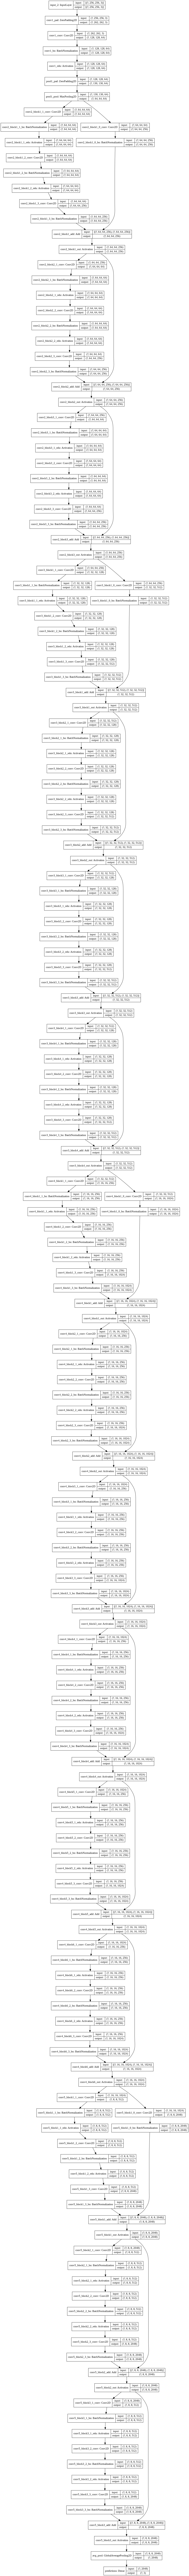

In [19]:
from tensorflow.keras.utils import plot_model

##Display the plot of the model
plot_model(model, show_shapes=True, show_layer_names=True)

Observe Residual connections

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, 252, 252, 4)  304         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 252, 252, 4)  404         conv2d_69[0][0]                  
__________________________________________________________________________________________________
batch_normalization_64 (BatchNo (None, 252, 252, 4)  16          conv2d_70[0][0]                  
____________________________________________________________________________________________

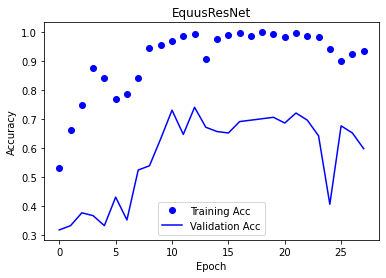

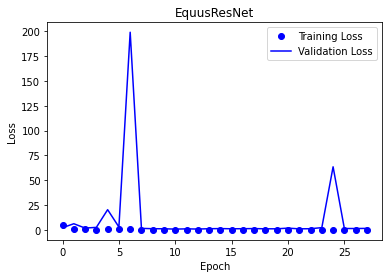

In [21]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

##Set the Residual blocks
input_img = Input(shape=(256, 256, 3))
output1 = Conv2D(4, (5, 5), activation='relu')(input_img)
for i in range(16):
    output2 = Conv2D(4, (5, 5), padding = 'same', activation='relu')(output1)
    output2 = BatchNormalization()(output2)
    output2 = Conv2D(4, (5, 5), padding = 'same', activation='relu')(output2)
    output2 = BatchNormalization()(output2)
    output2 = add([output1, output2])
    output1 = output2
output3 = Flatten()(output2)

##Attach the dense network from benchmark
output4 = Dense(units = 24, activation = 'relu')(output3)
output5 = Dense(units = 12, activation = 'relu')(output4)
output6 = Dense(units = 3, activation = 'softmax')(output5)
model = Model(inputs=input_img, outputs=output6)
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = 'EquusResNet.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [22]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 2s 66ms/step - loss: 0.8465 - accuracy: 0.6739
Test: {'accuracy': 0.6739130616188049, 'loss': 0.8465079665184021}
17/17 [==============================] - 1s 75ms/step - loss: 0.8215 - accuracy: 0.6520
Val: {'accuracy': 0.6519607901573181, 'loss': 0.8214903473854065}
61/61 [==============================] - 4s 66ms/step - loss: 0.0592 - accuracy: 0.9852
Train: {'accuracy': 0.9852458834648132, 'loss': 0.05916926637291908}


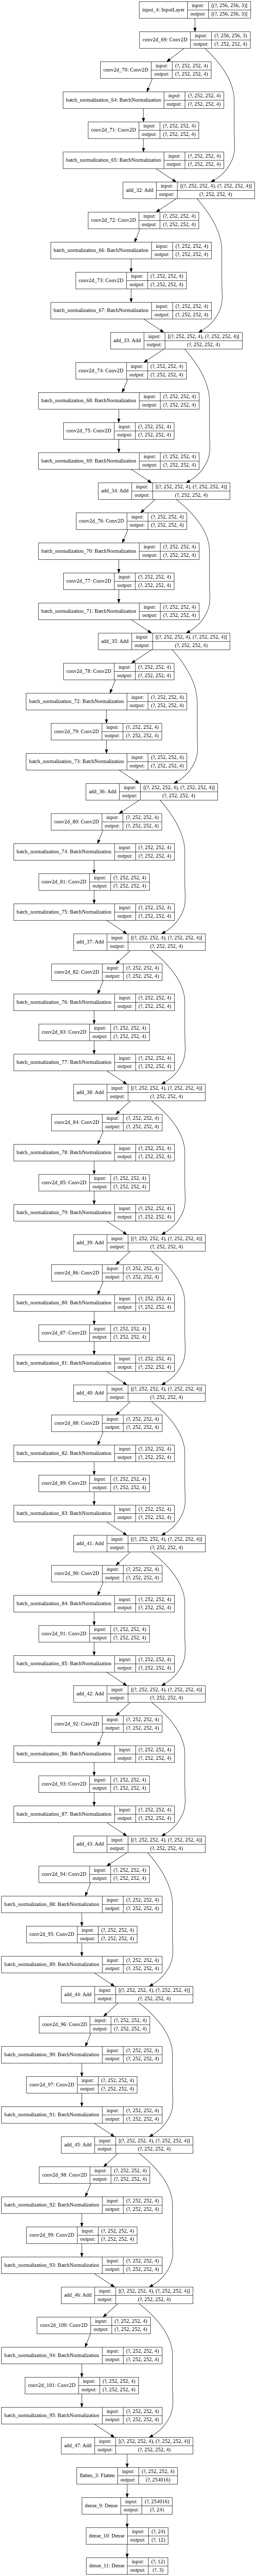

In [23]:
from tensorflow.keras.utils import plot_model

##Display the plot of the model
plot_model(model, show_shapes=True, show_layer_names=True)